<a href="https://colab.research.google.com/github/lipiecki/energy-analytics-2025/blob/main/notebooks/RegularizedRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shrinkage - lasso and ridge regression

In [1]:
import pandas as pd
import numpy as np
from scipy import optimize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### Load one of the included datasets - EPEX or GEFCom

In [2]:
dataset = "epex"
url = f"https://raw.githubusercontent.com/lipiecki/energy-analytics-2025/refs/heads/main/data/{dataset}.csv"
local = f"../data/{dataset}.csv"

In [3]:
df = pd.read_csv(url, delimiter=',', header=0, index_col=[0, 1])
df

price   load_da  load_real  day_of_week
date     hour                                          
20220101 0      50.05  41989.50   43915.50            6
         1      41.33  40105.50   41535.75            6
         2      43.22  38784.00   40480.75            6
         3      45.46  37751.00   39564.00            6
         4      37.67  37877.25   39338.25            6
...               ...       ...        ...          ...
20241231 19    200.00  56083.25   54868.50            2
         20    204.61  53423.00   51940.50            2
         21    186.25  50937.50   50559.50            2
         22    146.52  47657.50   49133.50            2
         23    141.68  45257.25   49607.50            2

[26304 rows x 4 columns]

### Prepare the explenatory variables for the regression models

In [4]:

df['lag1'] = df['price'].shift(24)  # price one day ago (24 hours)
df['lag2'] = df['price'].shift(48)  # price two days ago (48 hours)
df['lag7'] = df['price'].shift(168) # price seven days ago (168 hours)
df.dropna(inplace=True)
df

price   load_da  load_real  day_of_week    lag1    lag2  \
date     hour                                                             
20220108 0     164.17  51093.00   52694.75            6  128.92   99.85   
         1     152.83  49105.50   50532.50            6  118.40  101.32   
         2     166.00  48075.25   49608.25            6  103.01  110.01   
         3     160.86  47763.50   49543.25            6  101.91  111.55   
         4     160.00  47900.25   49077.25            6  101.98  123.37   
...               ...       ...        ...          ...     ...     ...   
20241231 19    200.00  56083.25   54868.50            2  165.93  206.72   
         20    204.61  53423.00   51940.50            2  184.44  194.97   
         21    186.25  50937.50   50559.50            2  203.88  195.95   
         22    146.52  47657.50   49133.50            2  168.46  167.31   
         23    141.68  45257.25   49607.50            2  162.92  149.98   

                 lag7  
date     hour          
20220108 0      50.05  
         1      41.33  
         2      43.22  
         3      45.46  
         4      37.67  
...               ...  
20241231 19    105.66  
         20    102.56  
         21     94.63  
         22     99.04  
         23     90.00  

[26136 rows x 7 columns]

### Define the class for solving a regression problem with L1 and L2 regularizations

In [5]:
class Regression:
    def __init__(self, n, l1=0, l2=0):
      """
      Construct an object for regularized linear regression.
      Args:
        n: number of inputs
        l1: L1 regularization parameter
        l2: L2 regularization parameter
      """
      self.weights = np.ones(n)/n
      self.bias = 0.0
      self.l1 = l1
      self.l2 = l2
    def predict(self, X):
      return np.matmul(X, self.weights) + self.bias

    def loss(self, weights, X, y):
      self.weights = weights[:-1]
      self.bias = weights[-1]
      mse = np.mean((self.predict(X) - y)**2)
      lasso_penalty = self.l1*np.sum(abs(self.weights))
      ridge_penalty = self.l2*np.sum(self.weights**2)
      return mse + lasso_penalty + ridge_penalty

    def fit(self, X, y):
      """
      Fit the regularized linear regression model.
      X must be a 2d numpy array, which rows correspond to samples and columns to variables.
      """
      w = optimize.minimize(self.loss, np.hstack((self.weights, self.bias)), args = (X, y), method = "BFGS")
      self.weights = w.x[:-1]
      self.bias = w.x[-1]
      return self


### Prepare the regressors and response, select the paramters and define variables for storing the results

In [6]:
X = np.array(df[['lag1', 'lag2', 'lag7', 'load_da']])
Y = np.array(df['price'])
window = 358 # 365 - maximum lag (7 days)
model_names = ['lreg', 'lasso', 'ridge']
periods = ['train', 'test']
params = {'lreg': [0, 0], 'lasso': [0.1, 0], 'ridge': [0, 1]}
losses = dict()
for model in model_names:
    for period in periods:
      losses[f'{model}-{period}'] = np.empty(24)
models = dict()

### Generate forecasts with specified models

In [7]:
for h in range(0, 24):
      # prepare training data
      Y_train= Y[h:window*24:24]
      X_train = None
      for h_inp in range(0, 24):  # in this setup, we use load forecast and lagged prices from all 24 hours
        Xh_train = X[h_inp:window*24:24, :]
        if X_train is None:
          X_train = Xh_train
        else:
          X_train = np.column_stack((X_train, Xh_train))

      # scale training data
      input_scaler = StandardScaler().fit(X_train)
      XZ_train = input_scaler.transform(X_train)
      output_scaler = StandardScaler().fit(Y_train.reshape(-1, 1))
      YZ_train = output_scaler.transform(Y_train.reshape(-1, 1)).flatten()

      # prepare test data
      Y_test = Y[window*24+h:len(df):24]
      X_test = None
      for h_inp in range(0, 24):  # in this setup, we use load forecast and lagged prices from all 24 hours
        Xh_test = X[window*24+h:len(df):24, :]
        if X_test is None:
          X_test = Xh_test
        else:
          X_test = np.column_stack((X_test, Xh_test))

      # scale testing data
      XZ_test = input_scaler.transform(X_test)
    
      # fit the model to training data
      for model in ['lreg', 'lasso', 'ridge']:
        reg = Regression(X_test.shape[1], l1=params[model][0], l2=params[model][1])
        reg = reg.fit(XZ_train, YZ_train)
        models[f'{model}-{h}'] = reg
        
        Y_pred = reg.predict(XZ_train)
        Y_pred = output_scaler.inverse_transform(Y_pred.reshape(-1, 1)).flatten()
        losses[f'{model}-train'][h] = np.sqrt(mean_squared_error(Y_pred, Y_train))
  
        Y_pred = reg.predict(XZ_test)
        Y_pred = output_scaler.inverse_transform(Y_pred.reshape(-1, 1)).flatten()
        losses[f'{model}-test'][h] = np.sqrt(mean_squared_error(Y_pred, Y_test))


### Plot the error measures on testing and training periods for each model

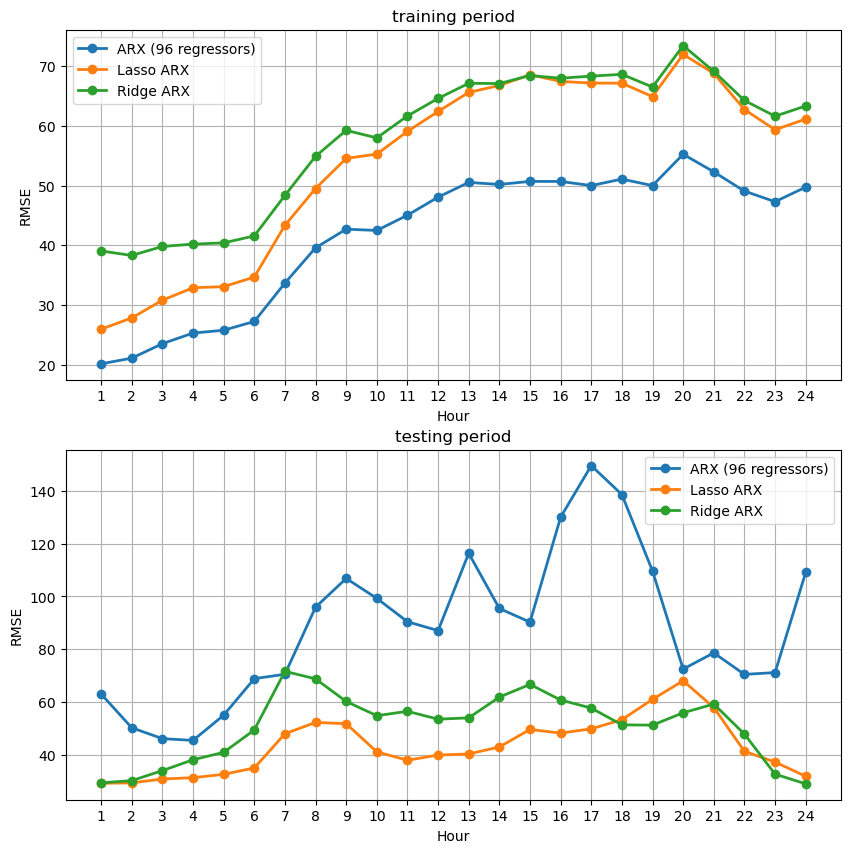

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
hours = range(1, 25)
for i in range(0, 2):
  period = periods[i]
  ax[i].plot(hours, losses[f'lreg-{period}'], '-o', color='tab:blue', linewidth=2, label = "ARX (96 regressors)")
  ax[i].plot(hours, losses[f'lasso-{period}'], '-o', color='tab:orange', linewidth=2, label = "Lasso ARX")
  ax[i].plot(hours, losses[f'ridge-{period}'], '-o', color='tab:green', linewidth=2, label = "Ridge ARX")
  ax[i].set_xlabel("Hour")
  ax[i].set_xticks(np.arange(1, 25))
  ax[i].grid()
  ax[i].legend()
  ax[i].set_ylabel("RMSE")
  ax[i].set_title(f"{period}ing period")
plt.show()

### Visualize the magnitude of weights for each model

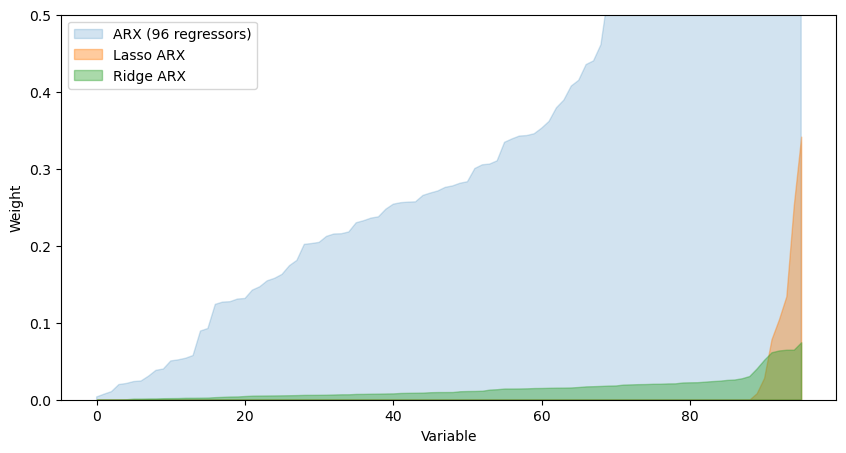

In [ ]:
hour = 19
arx_weights = np.sort(np.abs(models[f'lreg-{hour}'].weights))
lasso_weights = np.sort(np.abs(models[f'lasso-{hour}'].weights))
ridge_weights = np.sort(np.abs(models[f'ridge-{hour}'].weights))
plt.figure(figsize=(10, 5))
plt.fill_between(range(0, len(arx_weights)), arx_weights, np.zeros(len(arx_weights)), color="tab:blue", label="ARX (96 regressors)", alpha=0.2)
plt.fill_between(range(0, len(lasso_weights)), lasso_weights, np.zeros(len(lasso_weights)), color="tab:orange", label="Lasso ARX", alpha=0.4)
plt.fill_between(range(0, len(ridge_weights)), ridge_weights, np.zeros(len(ridge_weights)), color="tab:green", label="Ridge ARX", alpha=0.4)
plt.xlabel("Variable")
plt.ylabel("Weight")
plt.legend()
plt.ylim(0, 0.5)
plt.show()